In [1]:
from read_csv import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data05 = read_csv05('database/data05.csv')
data10 = read_csv10('database/data10.csv')
data20 = read_csv20('database/data20.csv')
print(data05.shape)
print(data10.shape)
print(data20.shape)

mean05 = np.mean(data05, axis=1)
mean10 = np.mean(data10, axis=1)
mean20 = np.mean(data20, axis=1)

data05_all = np.concatenate((data05[0], data05[1], data05[2], data05[3], data05[4]))


(5, 100)
(10, 10)
(20, 5)


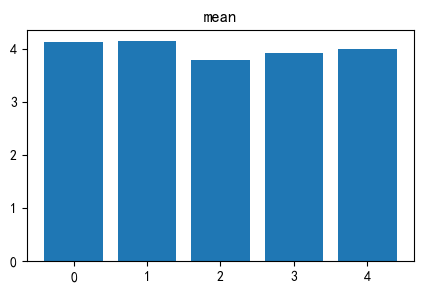

In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (5,3)
plt.title("mean")
x=range(5)
plt.bar(x,mean05)
plt.show()

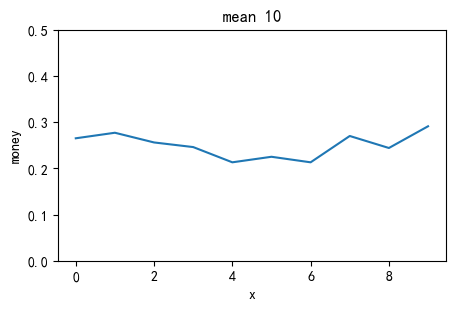

In [4]:
x = range(10)
plt.plot(x, mean10)
plt.title("mean 10")
plt.xlabel("x")
plt.ylabel("money")
plt.ylim(0, 0.5)
plt.show()

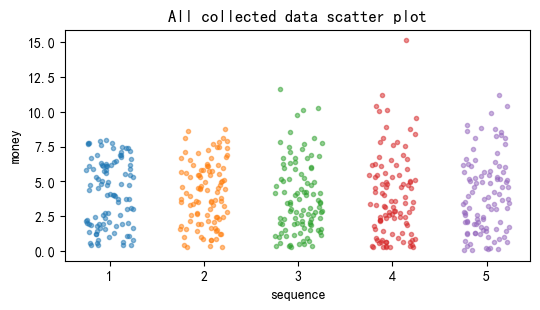

In [5]:
plt.figure(figsize=(6,3))
plt.xlabel("sequence")
plt.ylabel("money")
for i in range(5):
    x = np.random.random(100)
    x = x / 2 + i + 0.75
    plt.scatter(x, data05[i], marker='.', alpha=0.5)
plt.title("All collected data scatter plot")
plt.show()

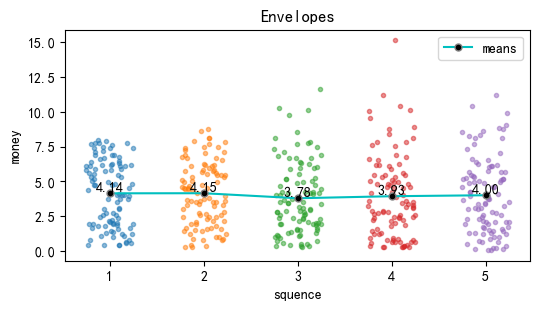

variance for each sqeuence:
[5.50708331 5.02952064 6.52382499 8.67529764 7.18975596]
standard deviation for each sqeuence:
[2.34671756 2.24265928 2.55417795 2.94538582 2.68137203]


In [6]:
plt.figure(figsize=(6,3))
for i in range(5):
    x = np.random.random(100)
    x = x / 2 + i + 0.75
    plt.scatter(x, data05[i], marker='.', alpha=0.5)
x_label = range(1, 6)
plt.plot(x_label,mean05,'c',label='means',markersize=5,markerfacecolor='black',marker='o',markeredgecolor='grey')
plt.xlabel("squence")
plt.ylabel("money")
plt.legend()
plt.title("Envelopes")
for i, j in zip(x_label, mean05):
    plt.text(i, j, '%.2f' % j, ha='center', va='bottom', fontsize=10)
plt.show()
print("variance for each sqeuence:")
print(np.var(data05, axis=1))
print("standard deviation for each sqeuence:")
print(np.std(data05, axis=1))

从直观来看，后抢的人更有可能抢到大红包，但先抢的人平均抢的金额更多。我们从第一个抢红包的人出发试图找出其分布规律。

413.86999999999995


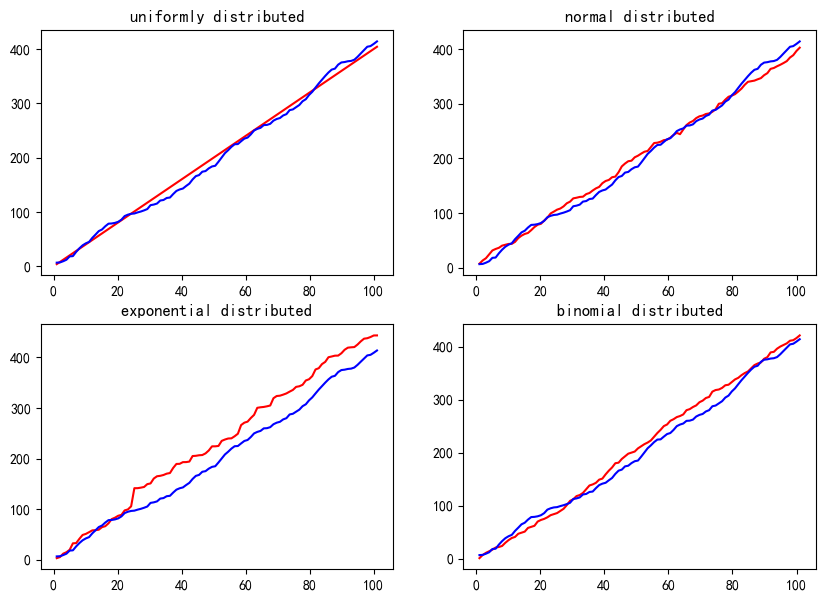

In [7]:
from find_distribution import *


data05_cdf0 = compute_cdf(data05[0])
print(data05_cdf0[99])


x_unif = np.linspace(1, 101, 100)
y_unif = x_unif * 4
# 2.3452 is obtained from sqrt of data05[0] variance
y_norm = np.random.normal(4, 2.3452, 100)
y_norm_cdf = compute_cdf(y_norm)
y_exp = np.random.exponential(4, 100)
y_exp_cdf = compute_cdf(y_exp)
y_binom = np.random.binomial(100, 0.04, 100)
y_binom_cdf = compute_cdf(y_binom)
plt.figure(figsize=(10, 7))
# uniformly distributed
plt.subplot(221)
plt.plot(x_unif, y_unif, 'r', label='y=x*4')
plt.plot(x_unif, data05_cdf0, 'b', label='cdf')
plt.title("uniformly distributed")
# normal distributed
plt.subplot(222)
plt.plot(x_unif, y_norm_cdf, 'r', label='y=x*4')
plt.plot(x_unif, data05_cdf0, 'b', label='cdf')
plt.title("normal distributed")
# exponential distributed
plt.subplot(223)
plt.plot(x_unif, y_exp_cdf, 'r', label='y=x*4')
plt.plot(x_unif, data05_cdf0, 'b', label='cdf')
plt.title("exponential distributed")
# binomial distributed
plt.subplot(224)
plt.plot(x_unif, y_binom_cdf, 'r', label='y=x*4')
plt.plot(x_unif, data05_cdf0, 'b', label='cdf')
plt.title("binomial distributed")
plt.show()

In [8]:
print("Loss of uniform distribution:", compute_loss(data05[0], np.zeros(100) + 4))
print("Loss of normal distribution:", compute_loss(data05[0], y_norm))
print("Loss of exponential distribution:", compute_loss(data05[0], y_exp))
print("Loss of binomial distribution:", compute_loss(data05[0], y_binom))

Loss of uniform distribution: 552.6321
Loss of normal distribution: 1077.8699347707561
Loss of exponential distribution: 2858.3300896223877
Loss of binomial distribution: 1020.5120999999999


KL散度也可用于判断

In [9]:
print("KL divergence of uniform distribution:", KL_divergence(data05[0], np.zeros(100) + 4))
print("KL divergence of normal distribution:", KL_divergence(data05[0], y_norm))
print("KL divergence of exponential distribution:", KL_divergence(data05[0], y_exp))
print("KL divergence of binomial distribution:", KL_divergence(data05[0], y_binom))

KL divergence of uniform distribution: 0.18228341699566947
KL divergence of normal distribution: inf
KL divergence of exponential distribution: 0.7233917033496347
KL divergence of binomial distribution: 0.32833931923957155


证明上限为2倍剩余平均值：

均匀分布checked。根据某微信内部代码，0.01~2倍平均值，即0.01~8，利用KS-test

In [10]:
# generate 500 random numbers that are uniformly distributed
unif_data = np.random.uniform(0, 8, 2000)
print(ks_compare(unif_data, data05[0]))

True


利用data05[0]的均匀分布性验证data05[1]~data05[4]的均匀分布性：

In [11]:
for i in range(5):
    for j in range(i + 1, 5):
        print("KS test compare sequence", i, "and sequence", j, ":", ks_compare(data05[i], data05[j]))

KS test compare sequence 0 and sequence 1 : True
KS test compare sequence 0 and sequence 2 : False
KS test compare sequence 0 and sequence 3 : True
KS test compare sequence 0 and sequence 4 : True
KS test compare sequence 1 and sequence 2 : True
KS test compare sequence 1 and sequence 3 : True
KS test compare sequence 1 and sequence 4 : True
KS test compare sequence 2 and sequence 3 : True
KS test compare sequence 2 and sequence 4 : True
KS test compare sequence 3 and sequence 4 : True


In [17]:
print(ks_2(data05[0], data05[2]))

KstestResult(statistic=0.16, pvalue=0.1548386665118475, statistic_location=4.24, statistic_sign=-1)


尽管0和2分布“不同”，但这仅仅是因为样本过小导致的。样本1，3，4分布与2相同可证明这一点。statistic和pvalue的过于接近也可以证明

以上可得出微信红包的随机算法。亦可通过数学严格证明。还缺图像验证data05[1]~[4]的数据范围。

接下来大量模拟，找出规律。

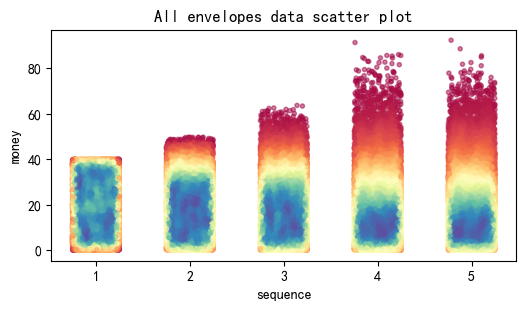

In [13]:
from envelope import *
from scipy.stats import gaussian_kde

envelopes = generate_envelopes(100, 5, 20000)
plt.figure(figsize=(6,3))
plt.xlabel("sequence")
plt.ylabel("money")
for i in range(5):
    x = np.random.random(20000)
    x = x / 2 + i + 0.75
    xy = np.vstack([x,envelopes[i]])
    z = gaussian_kde(xy)(xy) 
    plt.scatter(x, envelopes[i], c=z, marker='.', alpha=0.5, cmap='Spectral')
plt.title("All envelopes data scatter plot")
plt.show()

# about 16s

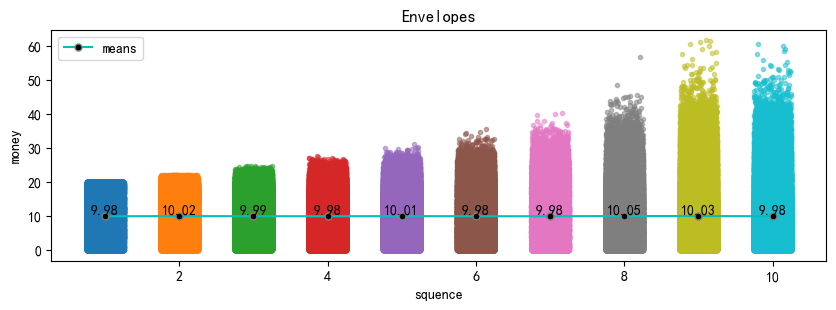

In [14]:
# envelopes = generate_envelopes(100, 10, 1000000)
# mean5 = np.mean(envelopes, axis=1)
# plt.figure(figsize=(6,3))
# plt.xlabel("sequence")
# plt.ylabel("money")
# for i in range(10):
#     x = np.random.random(1000000)
#     x = x / 2 + i + 0.75
#     plt.scatter(x, envelopes[i], marker='.', alpha=0.5)
# plt.title("All envelopes data scatter plot")
# x_label = range(1, 11)
# plt.plot(x_label,mean5,'c',label='means',markersize=5,markerfacecolor='black',marker='o',markeredgecolor='grey')
# plt.xlabel("squence")
# plt.ylabel("money")
# plt.legend()
# plt.title("Envelopes")
# for i, j in zip(x_label, mean5):
#     plt.text(i, j, '%.3f' % j, ha='center', va='bottom', fontsize=10)
# plt.show()
envelopes_10 = generate_envelopes(100, 10, 100000)
draw_envelope_graph(envelopes_10, 10, 100000)

# about 1 min

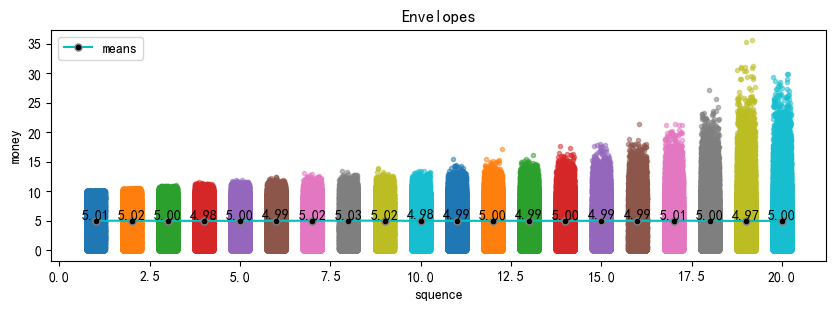

In [15]:
# envelopes = generate_envelopes(100, 20, 500000)
# mean_20 = np.mean(envelopes, axis=1)
# plt.figure(figsize=(8,3))
# plt.xlabel("sequence")
# plt.ylabel("money")
# for i in range(20):
#     x = np.random.random(500000)
#     x = x / 2 + i + 0.75
#     plt.scatter(x, envelopes[i], marker='.', alpha=0.5)
# plt.title("All envelopes data scatter plot")
# x_label = range(1, 21)
# plt.plot(x_label,mean_20,'c',label='means',markersize=5,markerfacecolor='black',marker='o',markeredgecolor='grey')
# plt.xlabel("squence")
# plt.ylabel("money")
# plt.legend()
# plt.title("Envelopes")
# for i, j in zip(x_label, mean_20):
#     plt.text(i, j, '%.2f' % j, ha='center', va='bottom', fontsize=10)
# plt.show()
envelopes_20 = generate_envelopes(100, 20, 50000)
draw_envelope_graph(envelopes_20, 20, 50000)

# about 1.5 min

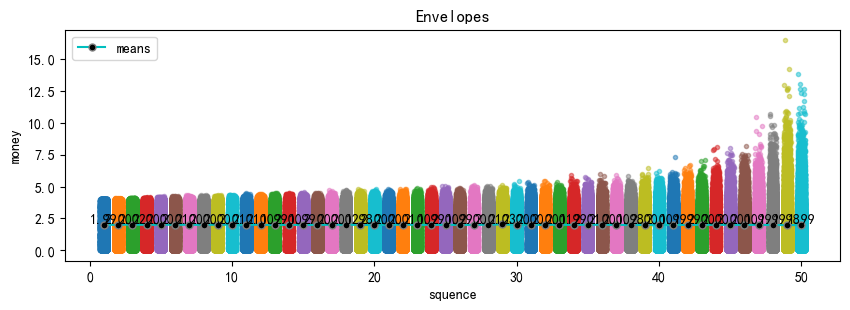

In [16]:
# envelopes = generate_envelopes(200, 50, 100000)
# mean_50 = np.mean(envelopes, axis=1)
# plt.figure(figsize=(11,3))
# plt.xlabel("sequence")
# plt.ylabel("money")
# for i in range(50):
#     x = np.random.random(100000)
#     x = x / 2 + i + 0.75
#     plt.scatter(x, envelopes[i], marker='.', alpha=0.5)
# plt.title("All envelopes data scatter plot")
# x_label = range(1, 51)
# plt.plot(x_label,mean_50,'c',label='means',markersize=5,markerfacecolor='black',marker='o',markeredgecolor='grey')
# plt.xlabel("squence")
# plt.ylabel("money")
# plt.legend()
# plt.title("Envelopes")
# for i, j in zip(x_label, mean_50):
#     plt.text(i, j, '%.1f' % j, ha='center', va='bottom', fontsize=10)
# plt.show()

envelopes_50 = generate_envelopes(100, 50, 20000)
draw_envelope_graph(envelopes_50, 50, 20000)

# about 40s